# Amazon Analysis

## Data Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3

In [3]:
#Saving the file in variable.

con = sqlite3.connect(r'/Users/ricardorojas/Library/CloudStorage/OneDrive-Personal/Data Analyst/Projects/Amazon Customers/database.sqlite')

In [4]:
type(con)

sqlite3.Connection

In [5]:
#Selecting all the data with a SQL statement.

df = pd.read_sql_query('SELECT * FROM REVIEWS', con)

In [6]:
df.shape

(568454, 10)

In [7]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data Pre-Processing

In [9]:
df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [10]:
df[df['HelpfulnessNumerator'] > df['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [11]:
'''Deleting the rows where the denominator (number of people who bought the product) is greater than the
numerator (number of people who leave a review)''' 

df_valid = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]


In [12]:
df_valid.shape

(568452, 10)

In [13]:
#Verifying if there are duplicates in the columns where it's impossible to have duplicates.

df_valid.duplicated(['UserId', 'ProfileName', 'Time', 'Text']).sum()

174521

In [14]:
#Errasing duplicates and saving the data in a new variable.

data = df_valid.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'])

In [15]:
data.shape

(393931, 10)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393931 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      393931 non-null  int64 
 1   ProductId               393931 non-null  object
 2   UserId                  393931 non-null  object
 3   ProfileName             393931 non-null  object
 4   HelpfulnessNumerator    393931 non-null  int64 
 5   HelpfulnessDenominator  393931 non-null  int64 
 6   Score                   393931 non-null  int64 
 7   Time                    393931 non-null  int64 
 8   Summary                 393931 non-null  object
 9   Text                    393931 non-null  object
dtypes: int64(5), object(5)
memory usage: 33.1+ MB


In [17]:
pd.to_datetime(data['Time'])

0        1970-01-01 00:00:01.303862400
1        1970-01-01 00:00:01.346976000
2        1970-01-01 00:00:01.219017600
3        1970-01-01 00:00:01.307923200
4        1970-01-01 00:00:01.350777600
                      ...             
568449   1970-01-01 00:00:01.299628800
568450   1970-01-01 00:00:01.331251200
568451   1970-01-01 00:00:01.329782400
568452   1970-01-01 00:00:01.331596800
568453   1970-01-01 00:00:01.338422400
Name: Time, Length: 393931, dtype: datetime64[ns]

In [18]:
#Changing unit from seconds to nanoseconds, to a get the correct date.

pd.to_datetime(data['Time'], unit='s')

0        2011-04-27
1        2012-09-07
2        2008-08-18
3        2011-06-13
4        2012-10-21
            ...    
568449   2011-03-09
568450   2012-03-09
568451   2012-02-21
568452   2012-03-13
568453   2012-05-31
Name: Time, Length: 393931, dtype: datetime64[ns]

In [19]:
from warnings import filterwarnings
filterwarnings('ignore')

In [20]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')

## Which users should Amazon make more recommendations to?

In [22]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...


In [23]:
#Grouping the information by User Id and aggregating functions to the corresponding columns.

more_products = data.groupby(['UserId']).agg({'Summary': 'count',
                             'Text': 'count',
                             'Score': 'mean',
                             'ProductId': 'count'})
more_products

,Summary,Text,Score,ProductId
UserId,,,,
#oc-R103C0QSV1DF5E,1,1,5.000000,1
#oc-R109MU5OBBZ59U,1,1,5.000000,1
#oc-R10LFEMQEW6QGZ,1,1,5.000000,1
#oc-R10LT57ZGIB140,1,1,3.000000,1
#oc-R10UA029WVWIUI,1,1,1.000000,1
...,...,...,...,...
AZZV9PDNMCOZW,3,3,4.666667,3
AZZVNIMTTMJH6,1,1,5.000000,1
AZZY649VYAHQS,1,1,5.000000,1


In [24]:
#Sorting rows in descending order of the Product Id column.

more_products = more_products.sort_values(by='ProductId', ascending=False)
more_products

,Summary,Text,Score,ProductId
UserId,,,,
AY12DBB0U420B,329,329,4.659574,329
A3OXHLG6DIBRW8,278,278,4.546763,278
A281NPSIMI1C2R,259,259,4.787645,259
A1YUL9PCJR3JTY,214,214,4.621495,214
A1Z54EM24Y40LL,211,211,4.383886,211
...,...,...,...,...
A2E80MDB9TCNGW,1,1,3.000000,1
A2E80RT3HOR35T,1,1,5.000000,1
A2E816C5N51F6X,1,1,5.000000,1


In [25]:
more_products.columns = ['Num_of_summaries', 'Num_text', 'Avg_score', 'Purchased_products']
more_products

,Num_of_summaries,Num_text,Avg_score,Purchased_products
UserId,,,,
AY12DBB0U420B,329,329,4.659574,329
A3OXHLG6DIBRW8,278,278,4.546763,278
A281NPSIMI1C2R,259,259,4.787645,259
A1YUL9PCJR3JTY,214,214,4.621495,214
A1Z54EM24Y40LL,211,211,4.383886,211
...,...,...,...,...
A2E80MDB9TCNGW,1,1,3.000000,1
A2E80RT3HOR35T,1,1,5.000000,1
A2E816C5N51F6X,1,1,5.000000,1


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'AY12DBB0U420B'),
  Text(1, 0, 'A3OXHLG6DIBRW8'),
  Text(2, 0, 'A281NPSIMI1C2R'),
  Text(3, 0, 'A1YUL9PCJR3JTY'),
  Text(4, 0, 'A1Z54EM24Y40LL'),
  Text(5, 0, 'A2MUGFV2TDQ47K'),
  Text(6, 0, 'A3D6OI36USYOU1'),
  Text(7, 0, 'AZV26LP92E6WU'),
  Text(8, 0, 'AKMEY1BSHSDG7'),
  Text(9, 0, 'A2GEZJHBV92EVR')])

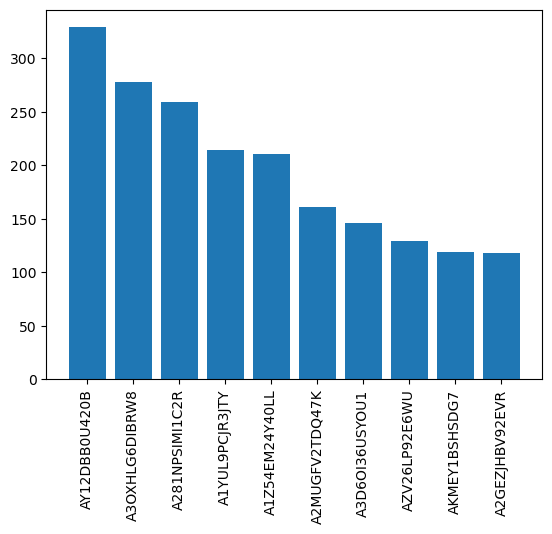

In [26]:
#To facilitate the code reading, we are saving the information in variables.

x = more_products.index[0:10]
y = more_products['Purchased_products'][0:10].values

plt.bar(x,y)
plt.xticks(rotation='vertical')

## Which product has a good number of reviews?

In [28]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [29]:
#Getting the total number of unique products.

len(data['ProductId'].unique())

67624

In [30]:
#I'm considering that a frequently sold product has been sold more than 500 times (randomly).

top5 = data.groupby('ProductId', as_index=False).size().sort_values(by='size', ascending=False)
top5.head(3)

,ProductId,size
65070,B007JFMH8M,912
38609,B002QWP89S,630
42176,B003B3OOPA,622


In [31]:
#Verifying with another method that these are the best-selling products.

top_5 = data['ProductId'].value_counts().to_frame()
top_5.head(3)

,ProductId
B007JFMH8M,912
B002QWP89S,630
B003B3OOPA,622


In [32]:
top_5['ProductId']>500

B007JFMH8M     True
B002QWP89S     True
B003B3OOPA     True
B001EO5Q64     True
B0013NUGDE     True
              ...  
B002DNX4GO    False
B000FM2YU2    False
B001M1VA32    False
B009858H6M    False
B001LR2CU2    False
Name: ProductId, Length: 67624, dtype: bool

In [33]:
#Using a filter to select the products that had been sold more than 500 times.

top_5[top_5['ProductId']>500]

,ProductId
B007JFMH8M,912
B002QWP89S,630
B003B3OOPA,622
B001EO5Q64,566
B0013NUGDE,558
B000KV61FC,556
B000UBD88A,542
B000NMJWZO,542
B005K4Q37A,541
B0090X8IPM,530


In [34]:
#Selecting the Product Ids and saving them in a variable.

freq_prod = top_5[top_5['ProductId']>500].index
freq_prod

Index(['B007JFMH8M', 'B002QWP89S', 'B003B3OOPA', 'B001EO5Q64', 'B0013NUGDE',
       'B000KV61FC', 'B000UBD88A', 'B000NMJWZO', 'B005K4Q37A', 'B0090X8IPM',
       'B005ZBZLT4'],
      dtype='object')

In [35]:
#Verifying the output to create a filter, in which rows do match our frequent products.

data['ProductId'].isin(freq_prod)

0         False
1         False
2         False
3         False
4         False
          ...  
568449    False
568450    False
568451    False
568452    False
568453    False
Name: ProductId, Length: 393931, dtype: bool

In [36]:
#Using the previous code as a filter.

freq_prod_df = data[data['ProductId'].isin(freq_prod)]
freq_prod_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
20982,20983,B002QWP89S,A21U4DR8M6I9QN,"K. M Merrill ""justine""",1,1,5,2011-10-18,addictive! but works for night coughing in dogs,my 12 year old sheltie has chronic brochotitis...
20983,20984,B002QWP89S,A17TDUBB4Z1PEC,jaded_green,1,1,5,2011-10-14,genuine Greenies best price,"These are genuine Greenies product, not a knoc..."
20984,20985,B002QWP89S,ABQH3WAWMSMBH,tenisbrat87,1,1,5,2011-09-28,Perfect for our little doggies,"Our dogs love Greenies, but of course, which d..."
20985,20986,B002QWP89S,AVTY5M74VA1BJ,tarotqueen,1,1,5,2011-09-24,dogs love greenies,"What can I say, dogs love greenies. They begg ..."
20986,20987,B002QWP89S,A13TNN54ZEAUB1,dcz2221,1,1,5,2011-09-23,Greenies review,This review is for a box of Greenies Lite for ...
...,...,...,...,...,...,...,...,...,...,...
563878,563879,B007JFMH8M,A366PSH7KFLRPB,TheRosySnail,0,0,5,2012-07-29,Yummy!,I loved these cookies and so did my kids. You ...
563879,563880,B007JFMH8M,A2KV6EYQPKJRR5,Kelley,0,0,5,2012-07-28,Quaker Soft Baked Cookies,This is a great tasting cookie. It is very sof...
563880,563881,B007JFMH8M,A3O7REI0OSV89M,Esme,0,0,4,2012-07-28,Delicious!,These are great for a quick snack! They are sa...
563881,563882,B007JFMH8M,A9JS5GQQ6GIQT,Syne,0,0,5,2012-07-28,yummy,I love the Quaker soft baked cookies. The rea...


In [37]:
freq_prod_df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

<Axes: xlabel='count', ylabel='ProductId'>

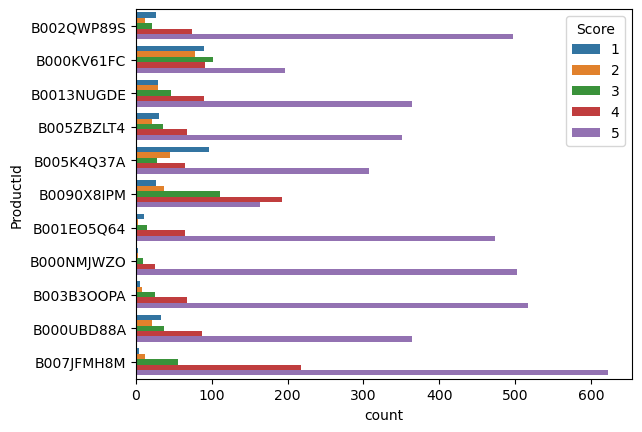

In [38]:
#Bar chart.

sns.countplot(y = 'ProductId', hue = 'Score', data=freq_prod_df)

## Understand if there is a difference in the behaviour of the frequent and non-frequent audience.

In [41]:
#Defining that a person who has bought more than 50 times falls in a frequent audience.
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,2011-03-09,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,2012-03-09,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,2012-02-21,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,2012-03-13,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [42]:
#Obtaining the buying frequence of each user.

frequency = data['UserId'].value_counts()
frequency

AY12DBB0U420B     329
A3OXHLG6DIBRW8    278
A281NPSIMI1C2R    259
A1YUL9PCJR3JTY    214
A1Z54EM24Y40LL    211
                 ... 
AAQPR1MSRXKTU       1
AGO81Z6PZSF7P       1
ALA84XWMTQBFT       1
A1G9DK8EUR36JC      1
A3LGQPJCZVL9UC      1
Name: UserId, Length: 256059, dtype: int64

In [44]:
#Creating a filter to separate the frequent clients from the non-frequent clients.
data['UserId'].apply(lambda user: 'Frequent' if frequency[user]>50 else 'Not Frequent')

0         Not Frequent
1         Not Frequent
2         Not Frequent
3         Not Frequent
4         Not Frequent
              ...     
568449    Not Frequent
568450    Not Frequent
568451    Not Frequent
568452    Not Frequent
568453    Not Frequent
Name: UserId, Length: 393931, dtype: object

In [45]:
#Create a new column to show if the clients are frequent o non-frequent.

data['Viewer_type'] = data['UserId'].apply(lambda user: 'Frequent' if frequency[user]>50 else 'Not Frequent')

In [46]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Frequent
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Not Frequent


In [47]:
data['Viewer_type'].unique()

array(['Not Frequent', 'Frequent'], dtype=object)

In [48]:
#Getting only the frequent clients.

freq_df = data[data['Viewer_type'] == 'Frequent']
freq_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,2010-03-12,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,Frequent
44,45,B001EO5QW8,A2G7B7FKP2O2PU,D. Leschke,0,0,5,2008-05-02,Great taste and convenience,We really like the McCann's steel cut oats but...,Frequent
46,47,B001EO5QW8,AQLL2R1PPR46X,grumpyrainbow,0,0,5,2007-10-19,good,Good oatmeal. I like the apple cinnamon the b...,Frequent
109,110,B001REEG6C,AY12DBB0U420B,Gary Peterson,0,0,5,2011-09-19,My Idea of a Good Diet Food.,I'm presently on a diet and I was at my Fresh ...,Frequent
141,142,B001GVISJW,A2YIO225BTKVPU,"Angel_Boy ""Treat the people around you the wa...",0,0,4,2011-04-03,Good Licorice,Twizzlers brand licorice is much better than t...,Frequent
...,...,...,...,...,...,...,...,...,...,...,...
568238,568239,B002OXLXLG,A1Z54EM24Y40LL,c2,0,0,5,2011-07-14,Great replacement for the Girl Scout version!,If you failed to purchase enough of the Mint G...,Frequent
568261,568262,B00374ZKQ0,A2GEZJHBV92EVR,History buff,0,0,5,2012-08-16,Very good alternative to sugar.,I have tried many of the no sugar sweeteners o...,Frequent
568317,568318,B0013Z0PTW,A1ODOGXEYECQQ8,Nuknuk,0,0,4,2008-11-17,Good Tasting Granola Bars,Most health bars taste awful. Fiber One Grano...,Frequent
568331,568332,B001BOAOLY,A36MP37DITBU6F,"Enchanted In Dixie ""Enchanted""",6,6,4,2009-06-08,GREAT ORGANIC Honey flavor Hard candy. Great c...,These are delicious organic hard candies. I on...,Frequent


In [49]:
#Getting only the non-frequent clients.

not_freq_df = data[data['Viewer_type'] == 'Not Frequent']
not_freq_df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Frequent
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Not Frequent
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,Not Frequent
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,Not Frequent
...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,2011-03-09,Will not do without,Great for sesame chicken..this is a good if no...,Not Frequent
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,2012-03-09,disappointed,I'm disappointed with the flavor. The chocolat...,Not Frequent
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,2012-02-21,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",Not Frequent
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,2012-03-13,Favorite Training and reward treat,These are the BEST treats for training and rew...,Not Frequent


In [50]:
#Obtain the percentages of each Score that frequent customers have given.

per_freq = freq_df['Score'].value_counts()/len(freq_df)*100
per_freq

5    61.605044
4    21.147681
3     9.585381
2     3.932464
1     3.729429
Name: Score, dtype: float64

In [51]:
#Obtain the percentages of each Score that non-frequent customers have given.

per_not_freq = not_freq_df['Score'].value_counts()/len(not_freq_df)*100
per_not_freq

5    63.757986
4    14.071191
1     9.349850
3     7.507547
2     5.313426
Name: Score, dtype: float64

<Axes: xlabel='Score', ylabel='Percentage'>

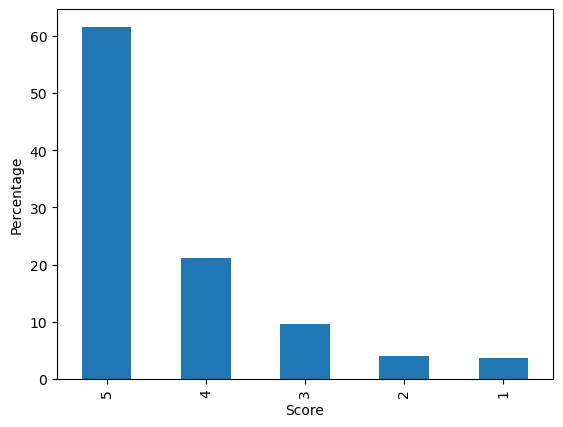

In [52]:
#Score percentage bar chart (frequent customers).

per_freq.plot(kind='bar', xlabel='Score', ylabel='Percentage')

<Axes: xlabel='Score', ylabel='Percentage'>

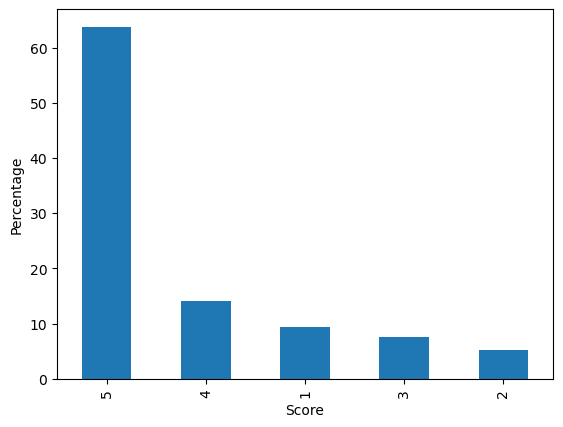

In [53]:
#Score percentage bar chart (non-frequent customers).

per_not_freq.plot(kind='bar', xlabel='Score', ylabel='Percentage')

## Research if the frequent customers leave more reviews and are more detailed in their reviews.

In [55]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Frequent
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Not Frequent


In [56]:
data[['UserId','ProductId', 'Text']]

,UserId,ProductId,Text
0,A3SGXH7AUHU8GW,B001E4KFG0,I have bought several of the Vitality canned d...
1,A1D87F6ZCVE5NK,B00813GRG4,Product arrived labeled as Jumbo Salted Peanut...
2,ABXLMWJIXXAIN,B000LQOCH0,This is a confection that has been around a fe...
3,A395BORC6FGVXV,B000UA0QIQ,If you are looking for the secret ingredient i...
4,A1UQRSCLF8GW1T,B006K2ZZ7K,Great taffy at a great price. There was a wid...
...,...,...,...
568449,A28KG5XORO54AY,B001EO7N10,Great for sesame chicken..this is a good if no...
568450,A3I8AFVPEE8KI5,B003S1WTCU,I'm disappointed with the flavor. The chocolat...
568451,A121AA1GQV751Z,B004I613EE,"These stars are small, so you can give 10-15 o..."
568452,A3IBEVCTXKNOH,B004I613EE,These are the BEST treats for training and rew...


In [57]:
#Verifyin how to change the strings into a list, in order to not take into account the white spaces.

len(data['Text'][0].split(' '))

49

In [58]:
#Create a function to change the strings into a list, in order to not take into account the white spaces.

def word_length(text):
    return len(text.split(' '))

In [59]:
#Creating a new column and applying the function to it.

data['Text_length'] = data['Text'].apply(word_length)
data['Text_length']

0         49
1         31
2         99
3         43
4         30
          ..
568449    26
568450    46
568451    71
568452    37
568453    21
Name: Text_length, Length: 393931, dtype: int64

In [60]:
#Separate the frequent from the non-frequent customers.

freq_data = data[data['Viewer_type'] == 'Frequent']
not_freq_data = data[data['Viewer_type'] == 'Not Frequent']

In [61]:
freq_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type,Text_length
14,15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,2010-03-12,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,Frequent,22
44,45,B001EO5QW8,A2G7B7FKP2O2PU,D. Leschke,0,0,5,2008-05-02,Great taste and convenience,We really like the McCann's steel cut oats but...,Frequent,44
46,47,B001EO5QW8,AQLL2R1PPR46X,grumpyrainbow,0,0,5,2007-10-19,good,Good oatmeal. I like the apple cinnamon the b...,Frequent,50
109,110,B001REEG6C,AY12DBB0U420B,Gary Peterson,0,0,5,2011-09-19,My Idea of a Good Diet Food.,I'm presently on a diet and I was at my Fresh ...,Frequent,134
141,142,B001GVISJW,A2YIO225BTKVPU,"Angel_Boy ""Treat the people around you the wa...",0,0,4,2011-04-03,Good Licorice,Twizzlers brand licorice is much better than t...,Frequent,47
...,...,...,...,...,...,...,...,...,...,...,...,...
568238,568239,B002OXLXLG,A1Z54EM24Y40LL,c2,0,0,5,2011-07-14,Great replacement for the Girl Scout version!,If you failed to purchase enough of the Mint G...,Frequent,111
568261,568262,B00374ZKQ0,A2GEZJHBV92EVR,History buff,0,0,5,2012-08-16,Very good alternative to sugar.,I have tried many of the no sugar sweeteners o...,Frequent,49
568317,568318,B0013Z0PTW,A1ODOGXEYECQQ8,Nuknuk,0,0,4,2008-11-17,Good Tasting Granola Bars,Most health bars taste awful. Fiber One Grano...,Frequent,65
568331,568332,B001BOAOLY,A36MP37DITBU6F,"Enchanted In Dixie ""Enchanted""",6,6,4,2009-06-08,GREAT ORGANIC Honey flavor Hard candy. Great c...,These are delicious organic hard candies. I on...,Frequent,60


(0.0, 500.0)

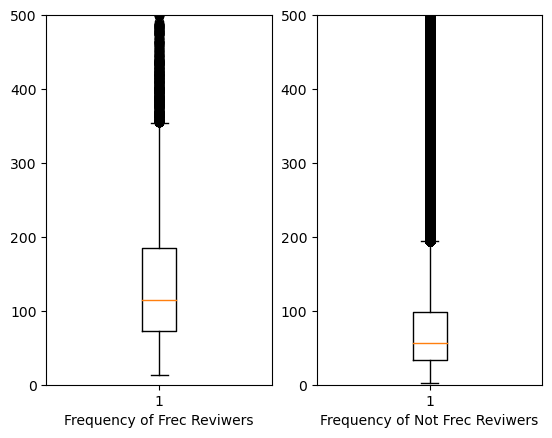

In [62]:
#Box plot in the frequency of reviews of frequent and non-frequent customers.

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.boxplot(freq_data['Text_length'])
ax1.set_xlabel('Frequency of Frec Reviwers')
ax1.set_ylim(0,500)

ax2 = fig.add_subplot(122)
ax2.boxplot(not_freq_data['Text_length'])
ax2.set_xlabel('Frequency of Not Frec Reviwers')
ax2.set_ylim(0,500)

## Sentiment Analysis

In [65]:
#Install texblob package for sentiment analysis.

from textblob import TextBlob

In [66]:
data['Summary'][0]

'Good Quality Dog Food'

In [67]:
#Testing the analysis sentiment.

TextBlob(data['Summary'][0]).sentiment

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)

In [68]:
TextBlob(data['Summary'][0]).sentiment.polarity

0.7

In [69]:
#Taking a sample of the first 50,000 reviews.

sample = data[0:50000]

In [70]:
#For each text it'll get the polarity and save it in the variable, if there is a mistake it'll add 0 to the variable.

polarity = []

for text in sample['Summary']:
    try:
        polarity.append(TextBlob(text).sentiment.polarity)
    except:
        polarity.append(0)

In [71]:
len(polarity)

50000

In [72]:
#Add the polarity column to the sample.

sample['polarity'] = polarity

In [73]:
sample.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type,Text_length,polarity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent,49,0.7
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Frequent,31,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,Not Frequent,99,0.0


In [74]:
neg_pol = sample[sample['polarity']<0]
neg_pol.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type,Text_length,polarity
16,17,B001GVISJM,A3KLWF6WQ5BNYO,Erica Neathery,0,0,2,2012-09-20,poor taste,I love eating them and they are good for watch...,Not Frequent,42,-0.400
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,2012-03-25,Nasty No flavor,"The candy is just red , No flavor . Just plan...",Not Frequent,22,-1.000
57,58,B004N5KULM,ASCNNAJU6SXF8,S. Beck,1,1,5,2012-05-05,How can you go wrong!,"It is chocolate, what can I say. Great variet...",Not Frequent,36,-0.625


In [75]:
pos_pol = sample[sample['polarity']>0]
pos_pol.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Viewer_type,Text_length,polarity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Not Frequent,49,0.7
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,Not Frequent,30,0.8
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,2012-07-12,Nice Taffy,I got a wild hair for taffy and ordered this f...,Not Frequent,72,0.6


In [76]:
from collections import Counter

In [78]:
#Obtaining the 10 key words most used.

Counter(neg_pol['Summary']).most_common(10)

[('Disappointed', 44),
 ('Disappointing', 32),
 ('Bland', 18),
 ('Awful', 17),
 ('Not what I expected', 17),
 ('Terrible', 15),
 ('Horrible', 15),
 ('disappointed', 15),
 ('Disgusting', 12),
 ('not good', 11)]

In [79]:
Counter(pos_pol['Summary']).most_common(10)

[('Delicious!', 208),
 ('Delicious', 204),
 ('Great product', 100),
 ('Excellent', 85),
 ('Love it!', 81),
 ('Great', 81),
 ('Great Product', 77),
 ('Great!', 70),
 ('Good stuff', 51),
 ('Awesome', 50)]